# Block Zone Simulator

This notebook / repo will be used to play around with block zone configurations and run simulations to determine the theoretical and practical capacity of an attraction.

In [1]:
# define blocks

blocks = {
    'station 1': {
        'next_block': 'lift 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': None,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': True,
        'hold_time': 38,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'station 2': {
        'next_block': 'lift 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': None,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': True,
        'hold_time': 38,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'lift 1': {
        'next_block': 'gravity 1',
        'seconds_to_reach_block': 18,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': True,
        'merger_block_a': 'station 1',
        'merger_block_b': 'station 2',
        'seconds_to_clear_merger': 2,
        'seconds_merger_to_block': 16,  # purely for reference at the moment
        'has_splitter_switch': False
    },
    'gravity 1': {
        'next_block': 'lift 2',
        'seconds_to_reach_block': 30,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'lift 2': {
        'next_block': 'gravity 2',
        'seconds_to_reach_block': 20,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'gravity 2': {
        'next_block': 'final block 1',
        'seconds_to_reach_block': 22,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'final block 1': {
        'next_block': 'station 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': True,
        'splitter_block_a': 'station 1',
        'splitter_block_b': 'station 2'
    }
}

# define optional params
optional_params = {
    'sluggishness': True,
    'sluggishness_mu': 1.5,
    'sluggishness_sigma': 0.6,
    'random_seed': 10
}

In [2]:
from circuit import Circuit

circuit = Circuit(blocks, num_trains=3, optional_params=optional_params)

In [20]:
# run the sim
for _ in range(36000):
    circuit.step()

Creating animation...
..........................................................................................................................................................................................................................................................................................................................................................................Animation saved.


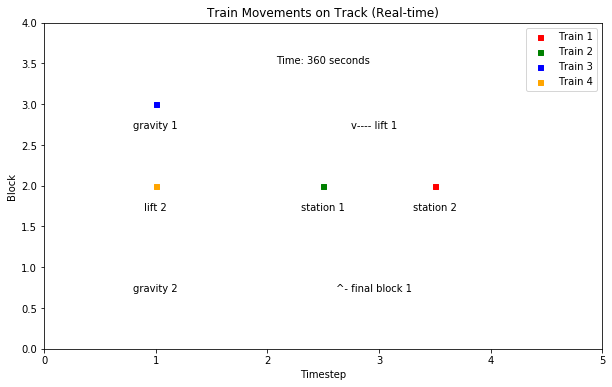

In [37]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML
import numpy as np
from IPython.display import clear_output

num_trains = 4
num_timesteps = 360
train_blocks = None  # Store current block
circuit = Circuit(blocks, num_trains=num_trains, optional_params=optional_params)

block_locs = {
    'station 1': (2.5, 2),
    'station 2': (3.5, 2),
    'lift 1': (3, 3),
    'gravity 1': (1, 3),
    'lift 2': (1, 2),
    'gravity 2': (1, 1),
    'final block 1': (3, 1),
}

block_txt = {block: block for block in circuit.blocks}
train_colors = ['red', 'green', 'blue', 'orange', 'purple', 'black']

# Simulation loop
def create_gif(num_timesteps):
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.xlabel("Timestep")
    plt.ylabel("Block")
    plt.title("Train Movements on Track (Real-time)")
    plt.ylim(0, 4)  # Adjust y-limit based on your block range
    plt.xlim(0, 5)
    scatters = [ax.scatter([], [], c=train_colors[i], s=25, marker='s', label=f"Train {i+1}") for i in range(num_trains)]
    texts = [ax.text(block_locs[b][0], block_locs[b][1] - 0.2, block_txt[b], ha='center', va='top') for b in circuit.blocks]
    texts.append(ax.text(2.5, 3.6, f'Time: 0 seconds', ha='center', va='top'))
    ax.legend()
    
    def animate(frame):
        # step simulation and update visualization for new frame=timestep
        circuit.step()
        print('.',end='')
        train_blocks = [block_locs[circuit.trains[t].current_block] for t in circuit.trains]
        if circuit.blocks['final block 1'].splitter_switch_position == 'station 1':
            block_txt['final block 1'] = '^- final block 1   '
        else:
            block_txt['final block 1'] = '   final block 1 -^'
        if circuit.blocks['lift 1'].merger_switch_position == 'station 1':
            block_txt['lift 1'] = 'v---- lift 1   '
        else:
            block_txt['lift 1'] = '   lift 1 ----v'

        # show labels for block areas
        i = 0
        for b in circuit.blocks:
            texts[i].set_text(block_txt[b])
            i += 1
        # update sim time
        texts[-1].set_text(f'Time: {frame+1} seconds')
        
        # Update the train locations
        for i in range(num_trains):
            scatters[i].set_offsets([(train_blocks[i][0], train_blocks[i][1])])
        
        return scatters
        
    anim = FuncAnimation(
        fig,
        animate,
        frames = num_timesteps,
        interval = 100,
        blit = True
    )

    return anim

print("Creating animation...")
anim = create_gif(num_timesteps)

writer = PillowWriter(fps=10) 
anim.save('train_animation.gif', writer=writer) 
print("Animation saved.")

# Display the animation in the notebook
#HTML(anim.to_jshtml()) 

## Simulation Animation - No GIF Creation

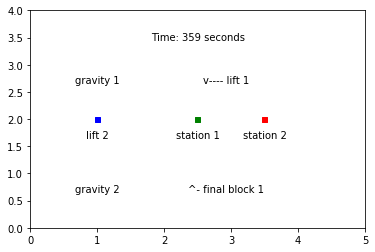

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Sample data (replace with your actual simulation data)
num_trains = 3
num_timesteps = 360
train_blocks = None  # Store current block
circuit = Circuit(blocks, num_trains=num_trains, optional_params=optional_params)

# Initialize the plot
plt.figure(figsize=(10, 6))
plt.xlabel("Timestep")
plt.ylabel("Block")
plt.title("Train Movements on Track (Real-time)")
plt.ylim(0, 4)  # Adjust y-limit based on your block range
plt.xlim(0, 5)
plt.ion()  # Turn on interactive mode

block_locs = {
    'station 1': (2.5, 2),
    'station 2': (3.5, 2),
    'lift 1': (3, 3),
    'gravity 1': (1, 3),
    'lift 2': (1, 2),
    'gravity 2': (1, 1),
    'final block 1': (3, 1),
}

block_txt = {block: block for block in circuit.blocks}

train_colors = ['red', 'green', 'blue', 'orange', 'purple', 'black']  # List of colors

# Simulation loop
for t in range(num_timesteps):
    # Simulate train movement (replace with your actual logic)
    circuit.step()
    train_blocks = [block_locs[circuit.trains[t].current_block] for t in circuit.trains]
    # splitter_switch_position
    if circuit.blocks['final block 1'].splitter_switch_position == 'station 1':
        block_txt['final block 1'] = '^- final block 1   '
    else:
        block_txt['final block 1'] = '   final block 1 -^'
    if circuit.blocks['lift 1'].merger_switch_position == 'station 1':
        block_txt['lift 1'] = 'v---- lift 1   '
    else:
        block_txt['lift 1'] = '   lift 1 ----v'
    # Clear the previous plot
    clear_output(wait=True)
    
    # show labels for block areas
    for b in block_locs:
        block_x, block_y = block_locs[b]
        plt.text(block_x, block_y - 0.2, block_txt[b], ha='center', va='top')
    plt.text(2.5, 3.6, f'Time: {t} seconds', ha='center', va='top')
    # Update the plot # color=train_colors[:num_trains]
    #plt.plot([x[0] for x in train_blocks], [x[1] for x in train_blocks], marker='s', linestyle='none')
    plt.scatter([x[0] for x in train_blocks], [x[1] for x in train_blocks], 
                c=train_colors[:num_trains], marker='s', s=25)
    plt.ylim(0, 4)  # Adjust y-limit based on your block range
    plt.xlim(0, 5)
    #plt.legend()  # [f"Train {i+1}" for i in range(num_trains)]
    plt.draw()
    plt.pause(0.01)  # Adjust pause time for animation speed

plt.ioff()  # Turn off interactive mode
plt.show()

In [6]:
#trains
#for train in circuit.trains:
#    print(vars(circuit.trains[train]))
#    print('')
    
#for block in circuit.blocks:
#    print(vars(circuit.blocks[block]))
#    print('')

In [22]:
# question - what percent of the sim run time did each train sit idle?
for train_name in circuit.trains:
    print(round(100*circuit.trains[train_name].total_seconds_held / circuit.time, 2))
    
# if we set run time to 1 million seconds, they all converge to the same % idle.

13.39
13.64
13.37
13.31
13.41


In [23]:
circuit.blocks

{'station 1': <block.Block at 0x1e59e7daef0>,
 'station 2': <block.Block at 0x1e59e7daf28>,
 'lift 1': <block.Block at 0x1e59e7da780>,
 'gravity 1': <block.Block at 0x1e59e7da4a8>,
 'lift 2': <block.Block at 0x1e59e7da908>,
 'gravity 2': <block.Block at 0x1e59e7da828>,
 'final block 1': <block.Block at 0x1e59e7dab38>}

In [24]:
num_riders_per_train = 24
avg_cycles_completed = sum([circuit.trains[train].circuits_completed for train in circuit.trains]) / len(circuit.trains)
avg_cycles_per_hour = avg_cycles_completed * 3600 / circuit.time
total_cycles_per_hour = avg_cycles_per_hour * len(circuit.trains)
total_hourly_capacity = num_riders_per_train * total_cycles_per_hour
total_hourly_capacity # 463 (1) 928.8 (2) 1394 (3) 1378 (4)

1939.1999999999998

In [25]:
import random
import numpy as np

rng = np.random.default_rng(10)


mean sluggishness:	 5.369
0th percentile: 	0.349
25th percentile: 	2.992
50th percentile: 	4.486
75th percentile: 	6.713
100th percentile: 	61.614


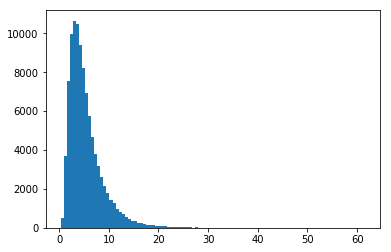

In [26]:
from matplotlib import pyplot as plt

simulated_sluggishness = rng.lognormal(mean=1.5, sigma=0.6, size=100000)
print(f"mean sluggishness:\t {round(simulated_sluggishness.mean(),3)}")
for p in [0, 25, 50, 75, 100]:
    print(f"{p}th percentile: \t{round(np.percentile(simulated_sluggishness,p),3)}")

plt.hist(simulated_sluggishness, bins=100)
plt.show()

# lognormal distribution with mean=1.5 and sigma=0.6 seems to give realistic load time slowdowns.
# mean is 5.34, or approx. 5 seconds above theoretical dispatch


## Example Study

### Comparing Theoretical vs. Actual Capacity

Using the toy example in this notebook, we can compare theoretical vs actual capacity with both simulated load/unload sluggishness and perfect dispatches.

In [28]:
from circuit import Circuit
import numpy as np
import pandas as pd

blocks = {
    'station 1': {
        'next_block': 'lift 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': None,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': True,
        'hold_time': 38,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'station 2': {
        'next_block': 'lift 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': None,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': True,
        'hold_time': 38,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'lift 1': {
        'next_block': 'gravity 1',
        'seconds_to_reach_block': 18,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': True,
        'merger_block_a': 'station 1',
        'merger_block_b': 'station 2',
        'seconds_to_clear_merger': 2,
        'seconds_merger_to_block': 16,  # purely for reference at the moment
        'has_splitter_switch': False
    },
    'gravity 1': {
        'next_block': 'lift 2',
        'seconds_to_reach_block': 30,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'lift 2': {
        'next_block': 'gravity 2',
        'seconds_to_reach_block': 20,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'gravity 2': {
        'next_block': 'final block 1',
        'seconds_to_reach_block': 22,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': False
    },
    'final block 1': {
        'next_block': 'station 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None,
        'has_merger_switch': False,
        'has_splitter_switch': True,
        'splitter_block_a': 'station 1',
        'splitter_block_b': 'station 2'
    }
}

optional_params = {
    'sluggishness': True,
    'sluggishness_mu': 1.5,
    'sluggishness_sigma': 0.6,
    'random_seed': 10
}

def calculate_hourly_capacity(vehicle_capacity, circuit):
    avg_cycles_completed = sum([circuit.trains[train].circuits_completed for train in circuit.trains]) / len(circuit.trains)
    avg_cycles_per_hour = avg_cycles_completed * 3600 / circuit.time
    total_cycles_per_hour = avg_cycles_per_hour * len(circuit.trains)
    total_hourly_capacity = vehicle_capacity * total_cycles_per_hour
    return total_hourly_capacity

theoretical_capacities = []
theoretical_idle_percents = []
actual_capacities = []
actual_idle_percents = []

sim_run_time = 36000  # 10 hours (60s * 60min * 10hr)

for n in [1, 2, 3, 4, 5, 6]:
    # run without sluggishness
    optional_params['sluggishness'] = False
    circuit = Circuit(blocks, num_trains=n, optional_params=optional_params)
    for _ in range(sim_run_time):
        circuit.step()
    # analyze results
    theoretical_capacities.append(calculate_hourly_capacity(vehicle_capacity=24, circuit=circuit))
    train_idles = []
    for train_name in circuit.trains:
        train_idles.append(100*circuit.trains[train_name].total_seconds_held / circuit.time)
    theoretical_idle_percents.append(round(np.mean(train_idles),2))
    # run again with sluggishness
    optional_params['sluggishness'] = True
    circuit = Circuit(blocks, num_trains=n, optional_params=optional_params)
    for _ in range(sim_run_time):
        circuit.step()
    actual_capacities.append(calculate_hourly_capacity(vehicle_capacity=24, circuit=circuit))
    train_idles = []
    for train_name in circuit.trains:
        train_idles.append(100*circuit.trains[train_name].total_seconds_held / circuit.time)
    actual_idle_percents.append(round(np.mean(train_idles),2))

df = pd.DataFrame({
    'num_trains': list(range(1,7)),
    'theoretical_capacity': theoretical_capacities,
    'actual_capacity': actual_capacities,
    'theoretical_idle_percents': theoretical_idle_percents,
    'actual_idle_percents': actual_idle_percents
})

df

,num_trains,theoretical_capacity,actual_capacity,theoretical_idle_percents,actual_idle_percents
0,1,463.2,453.6,0.00,0.00
1,2,748.8,734.4,18.91,18.61
2,3,1392.0,1353.6,0.02,0.11
3,4,1857.6,1797.6,0.02,0.45
4,5,1939.2,1939.2,15.70,13.42
5,6,1728.0,1728.0,32.69,31.02


From the above results, we can see that the highest theoretical capacity for this circuit with 7 complete block zones is 1,939 riders per hour, when operating 5 trains.  Operating six trains decreases this theoretical capacity.  Adding dispatch delay times to the simulation shows a decrease in achieved throughput when 4 or fewer trains are running.  It is interesting to see that delayed dispatched don't affect throughput when 5 or 6 trains are running.  This indicates that there is a bottleneck somewhere else in the layout and analyzing holding times at each individual block might give a better explanation.